In [0]:
pip install catboost

     |████████████████████████████████| 61.7MB 528kB/s 


In [0]:
!pip install ml_metrics

  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
!unzip -q Sangam_ML.zip

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import LabelEncoder

from ml_metrics import rmsle, msle

In [0]:
train = pd.read_csv('DataSets/Train.csv')
test = pd.read_csv('DataSets/Test.csv')

In [0]:
train = train[train.rain_p_h<11]
train = train[train.temperature>0]

In [0]:
train.wind_direction = train.wind_direction.apply(lambda x: 0 if x==360 else x)
test.wind_direction = test.wind_direction.apply(lambda x: 0 if x==360 else x)

In [0]:
train.date_time = pd.to_datetime(train.date_time, format='%Y-%m-%d %H:%M:%S')
test.date_time = pd.to_datetime(test.date_time, format='%Y-%m-%d %H:%M:%S')

In [0]:
train['hour'] = train.date_time.dt.hour
test['hour'] = test.date_time.dt.hour

In [0]:
train['date'] = train.date_time.dt.day
test['date'] = test.date_time.dt.day

In [0]:
train['weekday'] = train.date_time.dt.weekday
test['weekday'] = test.date_time.dt.weekday

In [0]:
train['month'] = train.date_time.dt.month
test['month'] = test.date_time.dt.month

In [0]:
train['holiday'] = train.is_holiday.apply(lambda x: 0 if x=='None' else 1)
test['holiday'] = test.is_holiday.apply(lambda x: 0 if x=='None' else 1)

In [0]:
train.drop(['is_holiday', 'visibility_in_miles'], axis=1, inplace=True)
test.drop(['is_holiday', 'visibility_in_miles'], axis=1, inplace=True)

In [0]:
wd = list(set(train.weather_description) - set(test.weather_description))
# for value in wd:
#     print(f'{value} : {train[train.weather_description==value].shape[0]}')
    
train = train[~train.weather_description.isin(wd)]

In [0]:
train.shape, test.shape

((33649, 18), (14454, 17))

In [0]:
for col in test.columns:
    print(f'{col} : {train[col].nunique()}, {test[col].nunique()}')

date_time : 28543, 11986
air_pollution_index : 290, 290
humidity : 88, 91
wind_speed : 17, 17
wind_direction : 360, 355
dew_point : 9, 9
temperature : 5610, 3334
rain_p_h : 319, 87
snow_p_h : 12, 1
clouds_all : 60, 19
weather_type : 10, 10
weather_description : 32, 32
hour : 24, 24
date : 31, 31
weekday : 7, 7
month : 12, 12
holiday : 2, 2


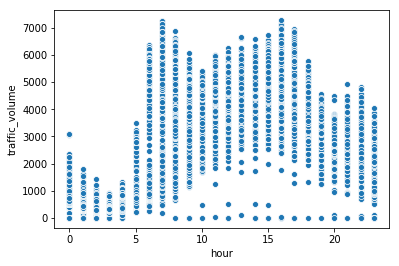

In [0]:
sns.scatterplot(train.hour, train.traffic_volume)

In [0]:
day_time = [i for i in range(6, 19)]
night_time = [19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
peak_time = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
off=[1,2,3,4,5,23]
train['day_time'] = train.hour.isin(day_time).astype(int)
# train['night_time'] = train.hour.isin(night_time).astype(int)
train['peak_time'] = train.hour.isin(peak_time).astype(int)
train['off'] = train.hour.isin(off).astype(int)

test['day_time'] = test.hour.isin(day_time).astype(int)
# test['night_time'] = test.hour.isin(night_time).astype(int)
test['peak_time'] = test.hour.isin(peak_time).astype(int)
test['off'] = test.hour.isin(off).astype(int)

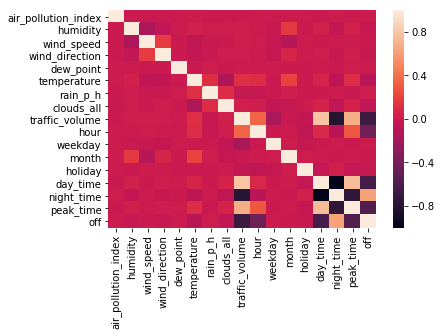

In [0]:
sns.heatmap(train.corr())

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5c1cfe8908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c1cfe8908>)

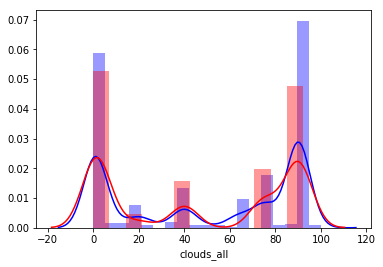

In [0]:
sns.distplot(train.clouds_all, color='b'), sns.distplot(test.clouds_all, color='r')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f49e40d65f8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f49e40d65f8>)

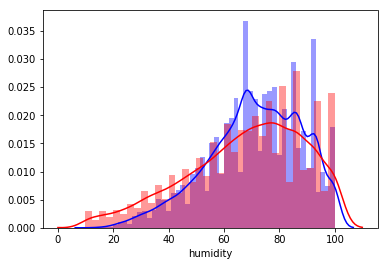

In [0]:
sns.distplot(train.humidity, color='b'), sns.distplot(test.humidity, color='r')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f49e40ade48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f49e40ade48>)

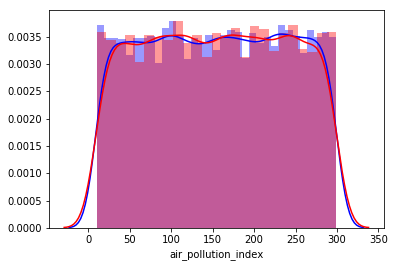

In [0]:
sns.distplot(train.air_pollution_index, color='b'), sns.distplot(test.air_pollution_index, color='r')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f49e048fc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f49e048fc88>)

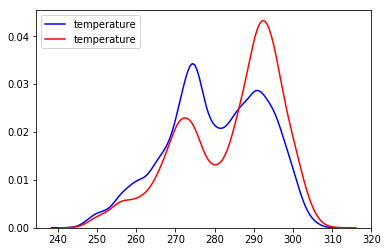

In [0]:
sns.kdeplot(train.temperature, color='b'), sns.kdeplot(test.temperature, color='r')

In [0]:
y = train.traffic_volume
train.drop('traffic_volume', axis=1, inplace=True)

In [0]:
train.drop('date_time', axis=1, inplace=True)
test.drop('date_time', axis=1, inplace=True)

In [0]:
assert train.shape[1]==test.shape[1]

In [0]:
pd.DataFrame(train.dtypes).reset_index()

,index,0
0,air_pollution_index,int64
1,humidity,int64
2,wind_speed,int64
3,wind_direction,int64
4,dew_point,int64
5,temperature,float64
6,rain_p_h,float64
7,snow_p_h,float64
8,clouds_all,int64
9,weather_type,object


In [0]:
le_weather_type = LabelEncoder()
le_weather_type.fit(train.weather_type)
train.weather_type = le_weather_type.transform(train.weather_type)
test.weather_type = le_weather_type.transform(test.weather_type)

In [0]:
le_weather_des = LabelEncoder()
le_weather_des.fit(train.weather_description)
train.weather_description = le_weather_des.transform(train.weather_description)
test.weather_description = le_weather_des.transform(test.weather_description)

In [0]:
cat_cols = [8, 9, 10, 11, 12, 13, 14,15,16,17,18]

In [0]:
xtrain, xvalid = train[:-6730], train[-6730:]

ytrain, yvalid = y[:-6730], y[-6730:]

In [0]:
def check_val(m):
    m.fit(xtrain, ytrain)
    pred = m.predict(xvalid)
    print(f'RMSLE : {rmsle(yvalid, pred)}')
    print(f'MSLE : {msle(yvalid, pred)}')
    
    return m

In [0]:
lgb = LGBMRegressor(num_leaves=90)
lgb.fit(xtrain, ytrain, categorical_feature=cat_cols)
pred = lgb.predict(xvalid)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [0]:
100-rmsle(yvalid, pred),100-msle(yvalid, pred)

(99.8355908405787, 99.97296962829839)

In [0]:
pd.DataFrame({'col':train.columns, 'importance':lgb.feature_importances_}).sort_values(by='importance', ascending=False)

,col,importance
12,date,1537
5,temperature,1459
11,hour,1018
14,month,932
3,wind_direction,827
13,weekday,709
1,humidity,654
0,air_pollution_index,308
2,wind_speed,289
10,weather_description,253


In [0]:
hist = HistGradientBoostingRegressor()
hist.fit(xtrain, ytrain)
pred = hist.predict(xvalid)

In [0]:
rmsle(yvalid, pred), 100-msle(yvalid, pred)

/usr/local/lib/python3.6/dist-packages/ml_metrics/elementwise.py:200: RuntimeWarning: invalid value encountered in log
  np.log(np.array(predicted)+1), 2))


(nan, nan)

In [0]:
clf = LGBMRegressor(num_leaves=90)
clf.fit(train, y, categorical_feature=cat_cols)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=90, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
predictions = clf.predict(test)
# predictions=np.power(predictions,3)

In [0]:
sub = pd.DataFrame()
sub['date_time'] = pd.read_csv('DataSets/Test.csv')['date_time']
sub['traffic_volume'] = predictions
sub.head()

,date_time,traffic_volume
0,2017-05-18 00:00:00,653.187530
1,2017-05-18 00:00:00,670.551085
2,2017-05-18 00:00:00,647.140415
3,2017-05-18 01:00:00,402.425638
4,2017-05-18 01:00:00,418.430748


In [0]:
sub = pd.DataFrame()
sub['date_time'] = pd.read_csv('DataSets/Test.csv')['date_time']
sub['traffic_volume'] = predictions
sub.head()

,date_time,traffic_volume
0,2017-05-18 00:00:00,745.656608
1,2017-05-18 00:00:00,781.369125
2,2017-05-18 00:00:00,752.732761
3,2017-05-18 01:00:00,548.328809
4,2017-05-18 01:00:00,574.258508


In [0]:
sub.to_csv('LGB_baseline_month_num_leaves_90_outlier_sigma_3.5.csv', index=False)

In [0]:
y_t=np.sqrt(y)

In [0]:
xtrain, xvalid = train[:-6730], train[-6730:]

ytrain, yvalid = y_t[:-6730], y_t[-6730:]

In [0]:
lgb = LGBMRegressor(num_leaves=90)
lgb.fit(xtrain, ytrain, categorical_feature=cat_cols)
pred = lgb.predict(xvalid)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [0]:
100-rmsle(yvalid, pred),100-msle(yvalid, pred)

(99.92195273460516, 99.9939086243644)

In [0]:
value_ = pd.read_csv('LGB_baseline.csv')['traffic_volume']
value_sqrt = pd.read_csv('LGB_baseline_sqrt.csv')['traffic_volume']

In [0]:
avg=(0.6*value_sqrt)+(0.4*value_)

In [0]:
sub = pd.DataFrame()
sub['date_time'] = pd.read_csv('DataSets/Test.csv')['date_time']
sub['traffic_volume'] = avg
sub.head()

,date_time,traffic_volume
0,2017-05-18 00:00:00,696.341452
1,2017-05-18 00:00:00,691.722673
2,2017-05-18 00:00:00,697.694867
3,2017-05-18 01:00:00,420.351714
4,2017-05-18 01:00:00,436.803266


In [0]:
sub.to_csv('LGB_6_sqrt_4_baseline.csv', index=False)

In [0]:
def find_outliers(model, X, y, sigma=3.5):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmsle=',rmsle(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.97069996189438
rmsle= nan
---------------------------------------
mean of residuals: -6.852304405697798e-09
std of residuals: 340.77713321021093
---------------------------------------
397 outliers:
[111, 115, 116, 696, 697, 1122, 1131, 1132, 1133, 1147, 1375, 1376, 1377, 1378, 1386, 1401, 1551, 1725, 1832, 2353, 2365, 2377, 2564, 2566, 3195, 3196, 3241, 3400, 3465, 3615, 3618, 3692, 3785, 3786, 4047, 4056, 4075, 4076, 4077, 4078, 4079, 4080, 4137, 4286, 4396, 4464, 4483, 4489, 4587, 4875, 4992, 4993, 4994, 4996, 4997, 4998, 4999, 5102, 5233, 5234, 5235, 5236, 5237, 5238, 5245, 5246, 5451, 5452, 5536, 5792, 5846, 6435, 6436, 6437, 6438, 6517, 6518, 7419, 7420, 7421, 7422, 7430, 7431, 7437, 7690, 7771, 8583, 8746, 8747, 8748, 8749, 8750, 8782, 8905, 9246, 9300, 9313, 9314, 9318, 9450, 9654, 9655, 9836, 10050, 10060, 10066, 10186, 10187, 10188, 10189, 10195, 10196, 10197, 10210, 10211, 10250, 10392, 10393, 10416, 10417, 10587, 10759, 10944, 10965, 10966, 11127, 11137, 11139, 11262,

/usr/local/lib/python3.6/dist-packages/ml_metrics/elementwise.py:200: RuntimeWarning: invalid value encountered in log
  np.log(np.array(predicted)+1), 2))


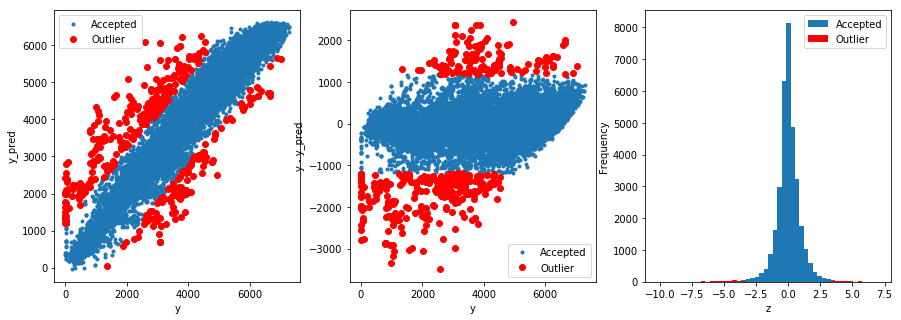

In [0]:
outliers = find_outliers(LGBMRegressor(), train, y)

In [0]:
train.drop(outliers,inplace=True)

In [0]:
y.drop(outliers,inplace=True)

In [0]:
train.drop('traffic_volume',1,inplace=True)